**ФИО:** Волгин Алексей Дмитриевич


**Задание**   Создать модель для решения задачи прогнозирования временных рядов с использованием фреймворка Keras.

В этой работе булем решать задачу прогнозирования временных рядов с использованием фреймворка Keras. В ноутбуке ниже приведен пример создания нейронной сети для прогнозирования курса акций (ссылка на датасет https://drive.google.com/file/d/1-KZEQkXhtGPSraSToJEkldZtGbZX30ap/view?usp=sharing).

В задании для самостоятельной разработки необходимо загрузить датасет и создать 3 архитектуры сети с использованием полносвязной архитектуры, одномерной свертки и рекуррентного слоя (MLP, Conv1D, LSTM).


**Основные понятия статистического анализа временных рядов:**

**Тренд** - компонента, описывающая долгосрочное изменение уровня ряда.

**Сезонность** - компонента, обозначаемая как Q, описывает циклические изменения уровня ряда.

**Ошибка**(random noise) - непрогнозируемая случайная компонента, описывает нерегулярные изменения в данных, необъяснимые другими компонентами.

**Автокорреляция** -статистическая взаимосвязь между последовательностями величин одного ряда. Это один из самых важных коэффициентов в анализе временного ряда. Чтобы посчитать автокорреляцию, используется корреляция между временным рядом и её сдвинутой копией от величины временного сдвига. Сдвиг ряда называется лагом.

**Автокорреляционная функция**- график автокорреляции при разных лагах.

**Стационарный ряд** - ряд, в котором свойства не зависят от времени.



**Импорт библиотек**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils

import numpy as np
from keras import layers
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D,  LSTM, GlobalMaxPooling1D, MaxPooling1D
import gdown

import os
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gdown
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

**Загрузка данных**

In [1]:
base_data = pd.read_csv('/content/Course.csv', sep=';')
# Выведем информацию о датасете
base_data.head()

NameError: name 'pd' is not defined

In [ ]:

base_data = pd.read_csv('/content/Course.csv', sep=';').drop(columns=['DATE', 'TIME']) # удалим лишние столбцы

In [ ]:
data =base_data.to_numpy()

In [ ]:
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume'] # Названия каналов для предсказания (столбцов)
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}

**Вывод графиков**

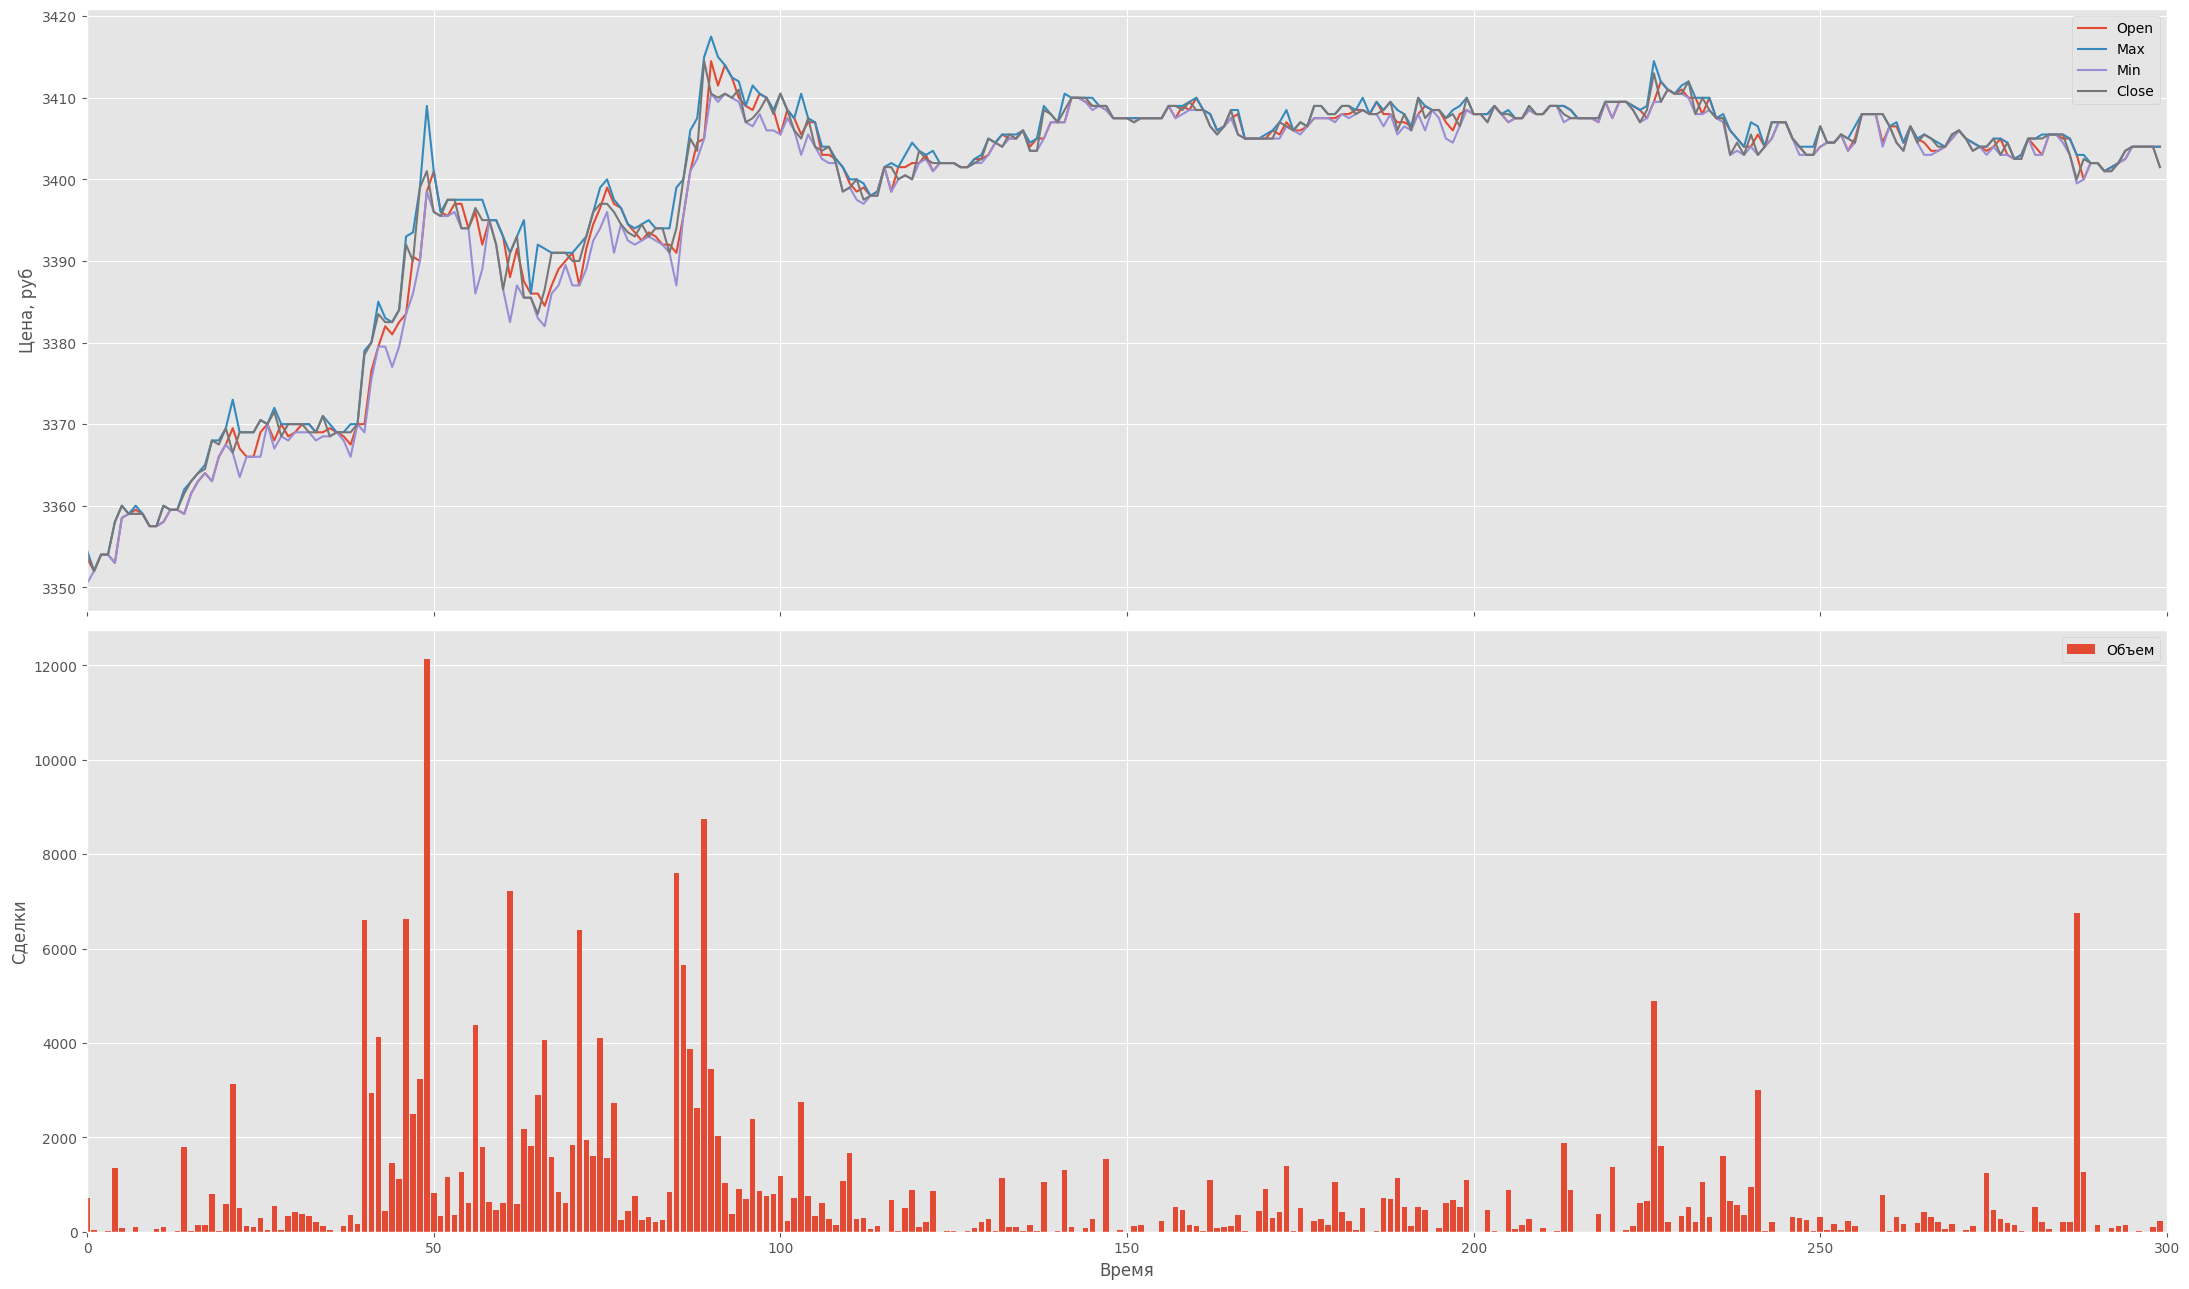

In [ ]:
# Выведем графики курса 'Open', 'Max', 'Min', 'Close', - на одном графике,  'Volume'- на другом
# Задание параметров, начальная точка и длина окна, которым будем проходить по ряду
start = 20
length = 300
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 13), sharex=True)
for chn in range(4):

    ax1.plot(data[start:start + length, chn],
             label=CHANNEL_NAMES[chn])
ax1.set_ylabel('Цена, руб')
ax1.legend()
# Канал volume (объем)
ax2.bar(x=np.arange(length),
        height=data[start:start + length, CHANNEL_INDEX['Volume']],
        label='Объем')
ax2.set_ylabel('Сделки')
ax2.legend()
plt.xlabel('Время')
# Регулировка пределов оси x
plt.xlim(0, length)
plt.tight_layout()
plt.show()

In [ ]:
# Словарь каналов данных с их индексами
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


In [ ]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 32                           # Объем батча для генератора
TEST_LEN = 30000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

**Подготовка данных для обучения**.
Разделение данных на тренировочный и тестовый наборы, прохождение окном по наборам, масштабирование и создание генераторов обучающей и валидационной выбоки.

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения

#TRAIN_LEN — это длина тренировочного набора, а 2 * SEQ_LEN используется как
#разрыв между тренировочными и тестовыми данными, чтобы избежать перекрытия.
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()                             #нормализует значения в диапазоне от 0 до 1
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

#  генератор для валидации при обучении
#TimeseriesGenerator используется для создания генератора, который будет выдавать последовательности временных рядов для обучения модели.
#length=SEQ_LEN указывает длину каждой последовательности, а batch_size=BATCH_SIZE — размер батча.
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4] [3]
Train data: (13000, 5), (13000, 1)
Test  data: (29400, 5), (29400, 1)
Train batch x: (32, 300, 5), y: (32, 1)


In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (29100, 300, 5), y: (29100, 1)


In [ ]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и денормализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [ ]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [ ]:
def eval_net(model,
             x_test, y_test,
             y_scaler,
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):

    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')


In [ ]:

def train_eval_net(model,
                   train_datagen, val_datagen,
                   epoch_list,
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=30,
                   title=''):

    model.summary()

    for epochs, opt in epoch_list:
        model.compile(loss='mse', optimizer=opt)
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

**Создание и обучение полносвязной модели сети**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300, 150)          900       
                                                                 
 flatten (Flatten)           (None, 45000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 45001     
                                                                 
Total params: 45901 (179.30 KB)
Trainable params: 45901 (179.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Обучение 10 эпох
Epoch 1/10
397/397 [==============================] - 6s 10ms/step - loss: 0.0094 - val_loss: nan
Epoch 2/10
397/397 [==============================] - 3s 9ms/step - loss: 0.0013 - val_loss: nan
Epoch 3/10
397/397 [==============================] - 4s 11ms/step - l

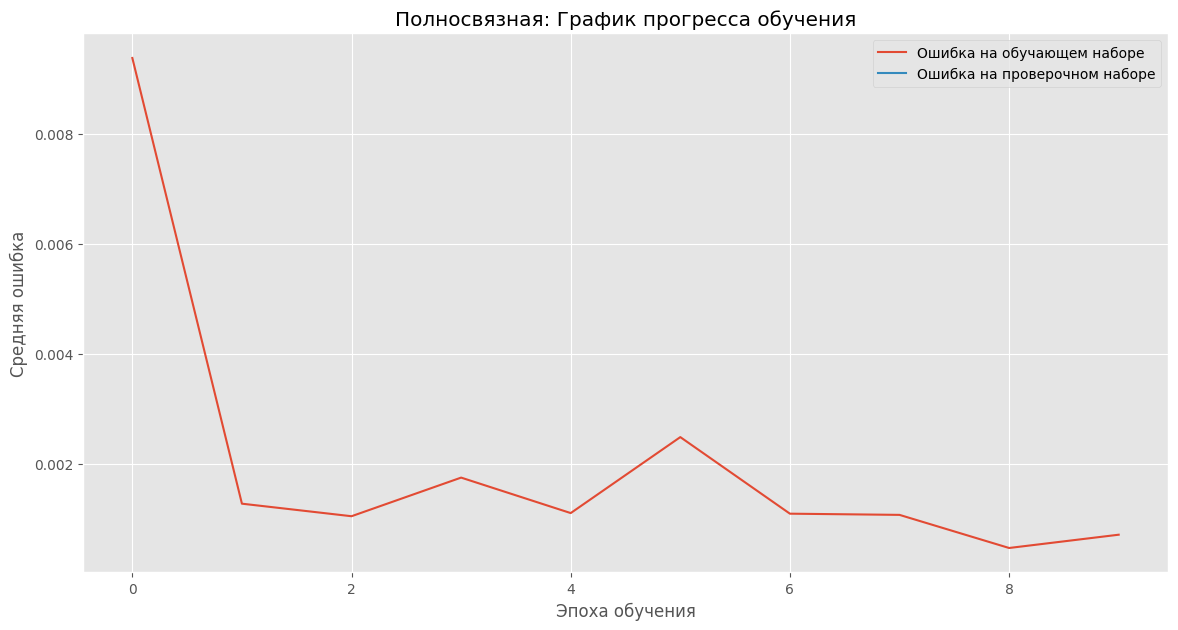

910/910 [==============================] - 2s 2ms/step


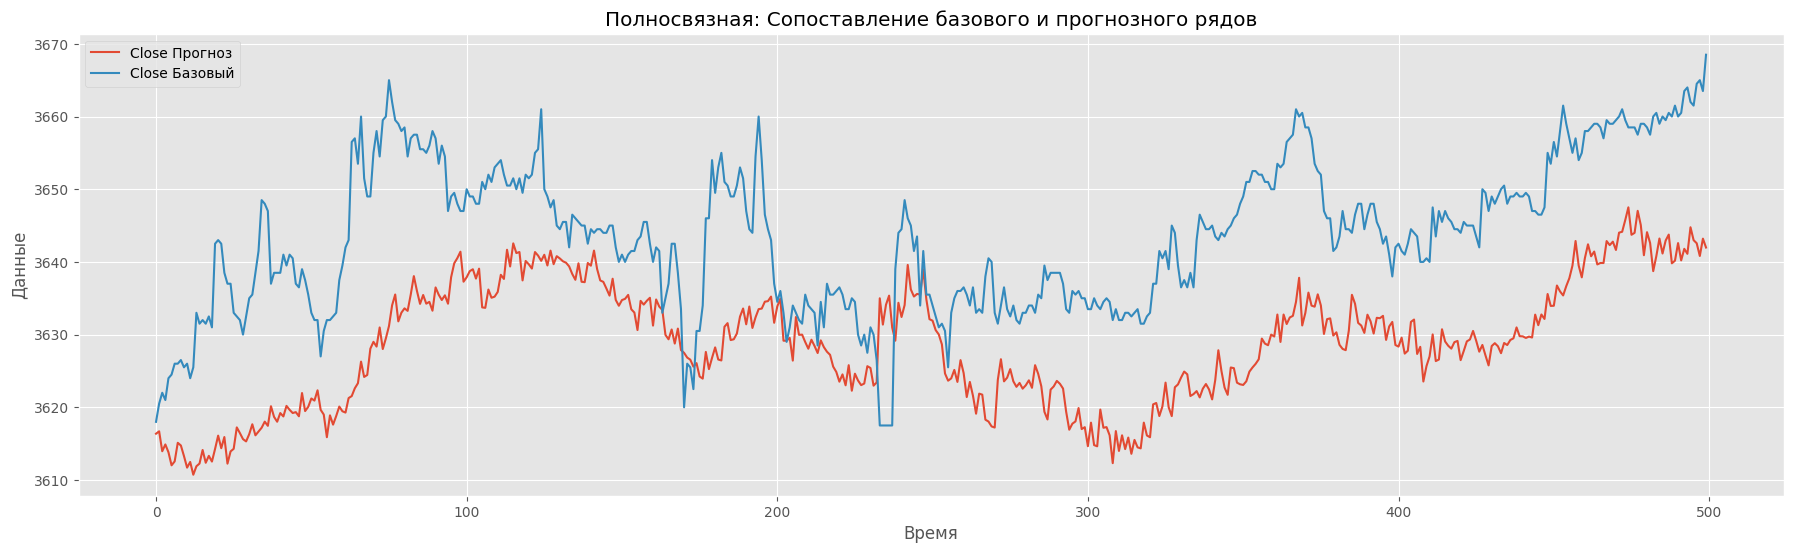

Обучение 25 эпох
Epoch 1/25
397/397 [==============================] - 4s 9ms/step - loss: 2.4798e-04 - val_loss: nan
Epoch 2/25
397/397 [==============================] - 4s 10ms/step - loss: 2.5161e-04 - val_loss: nan
Epoch 3/25
397/397 [==============================] - 4s 10ms/step - loss: 2.0897e-04 - val_loss: nan
Epoch 4/25
397/397 [==============================] - 3s 9ms/step - loss: 2.9303e-04 - val_loss: nan
Epoch 5/25
397/397 [==============================] - 4s 10ms/step - loss: 1.9664e-04 - val_loss: nan
Epoch 6/25
397/397 [==============================] - 3s 8ms/step - loss: 1.9476e-04 - val_loss: nan
Epoch 7/25
397/397 [==============================] - 3s 8ms/step - loss: 2.2283e-04 - val_loss: nan
Epoch 8/25
397/397 [==============================] - 4s 10ms/step - loss: 2.1967e-04 - val_loss: nan
Epoch 9/25
397/397 [==============================] - 3s 9ms/step - loss: 1.9831e-04 - val_loss: nan
Epoch 10/25
397/397 [==============================] - 3s 9ms/step - l

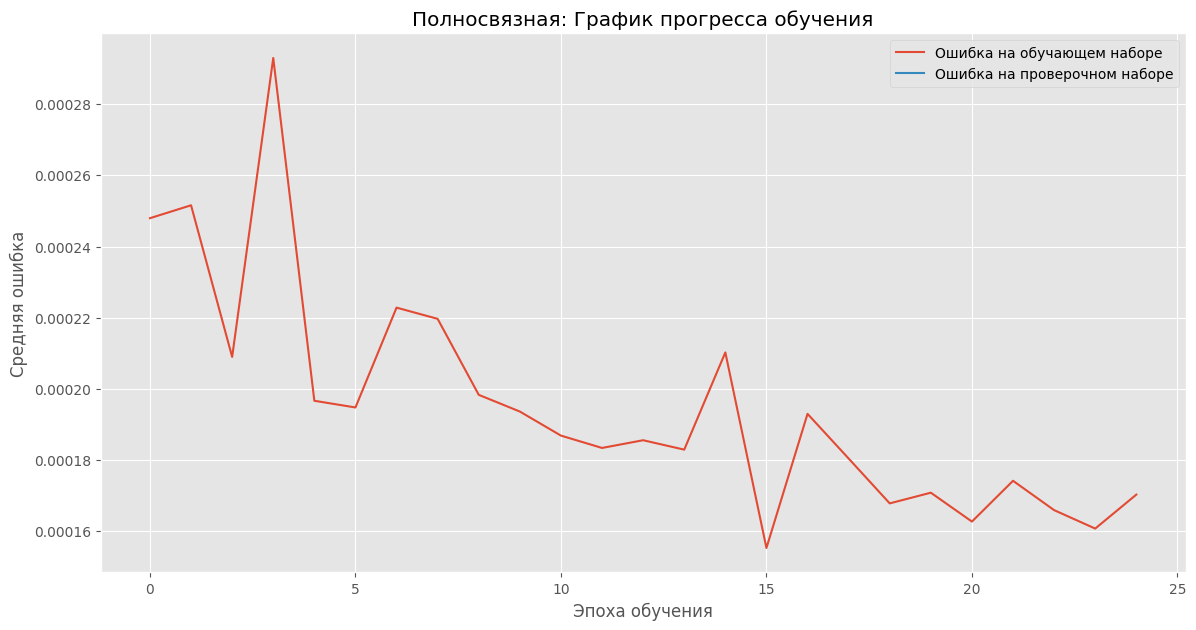

910/910 [==============================] - 2s 2ms/step


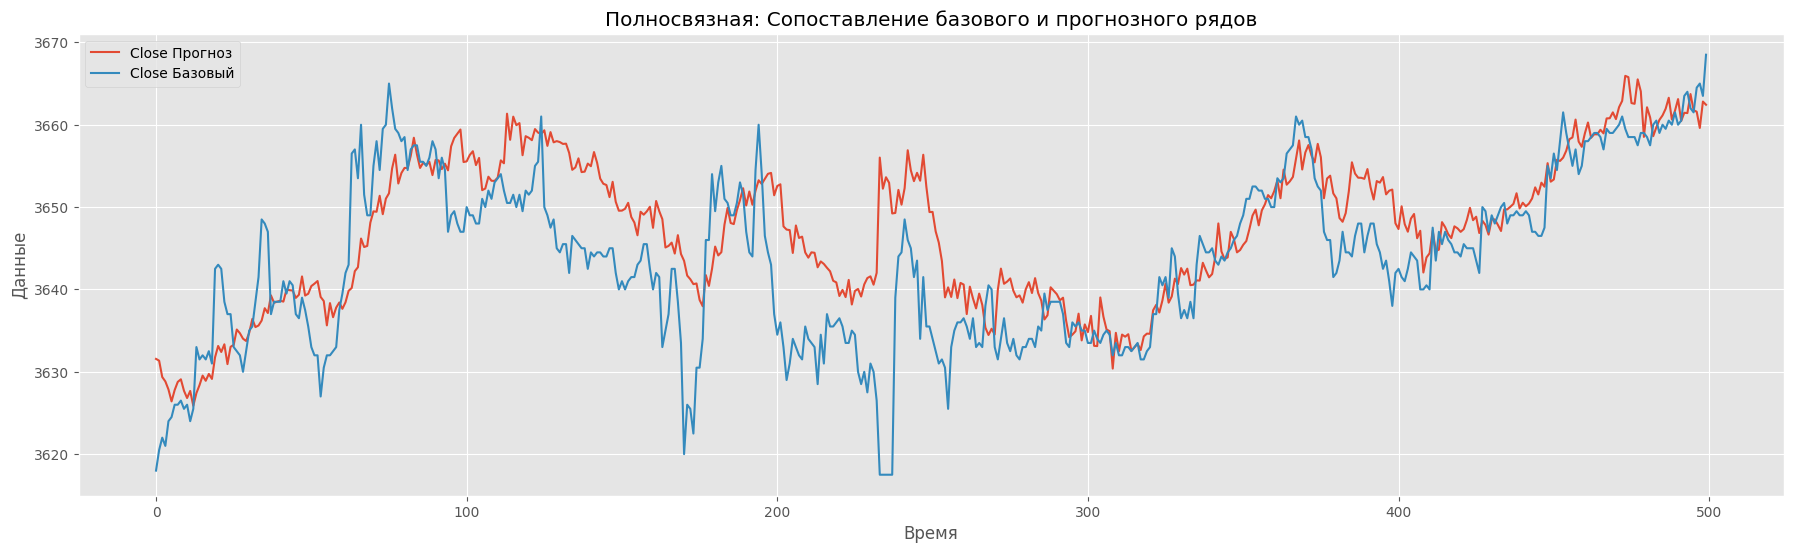

Обучение 25 эпох
Epoch 1/25
397/397 [==============================] - 5s 10ms/step - loss: 1.1934e-04 - val_loss: nan
Epoch 2/25
397/397 [==============================] - 4s 10ms/step - loss: 1.1574e-04 - val_loss: nan
Epoch 3/25
397/397 [==============================] - 3s 9ms/step - loss: 1.1342e-04 - val_loss: nan
Epoch 4/25
397/397 [==============================] - 4s 11ms/step - loss: 1.1620e-04 - val_loss: nan
Epoch 5/25
397/397 [==============================] - 3s 9ms/step - loss: 1.1623e-04 - val_loss: nan
Epoch 6/25
397/397 [==============================] - 4s 10ms/step - loss: 1.1434e-04 - val_loss: nan
Epoch 7/25
397/397 [==============================] - 4s 10ms/step - loss: 1.1090e-04 - val_loss: nan
Epoch 8/25
397/397 [==============================] - 4s 9ms/step - loss: 1.1326e-04 - val_loss: nan
Epoch 9/25
397/397 [==============================] - 4s 9ms/step - loss: 1.1353e-04 - val_loss: nan
Epoch 10/25
397/397 [==============================] - 7s 18ms/step -

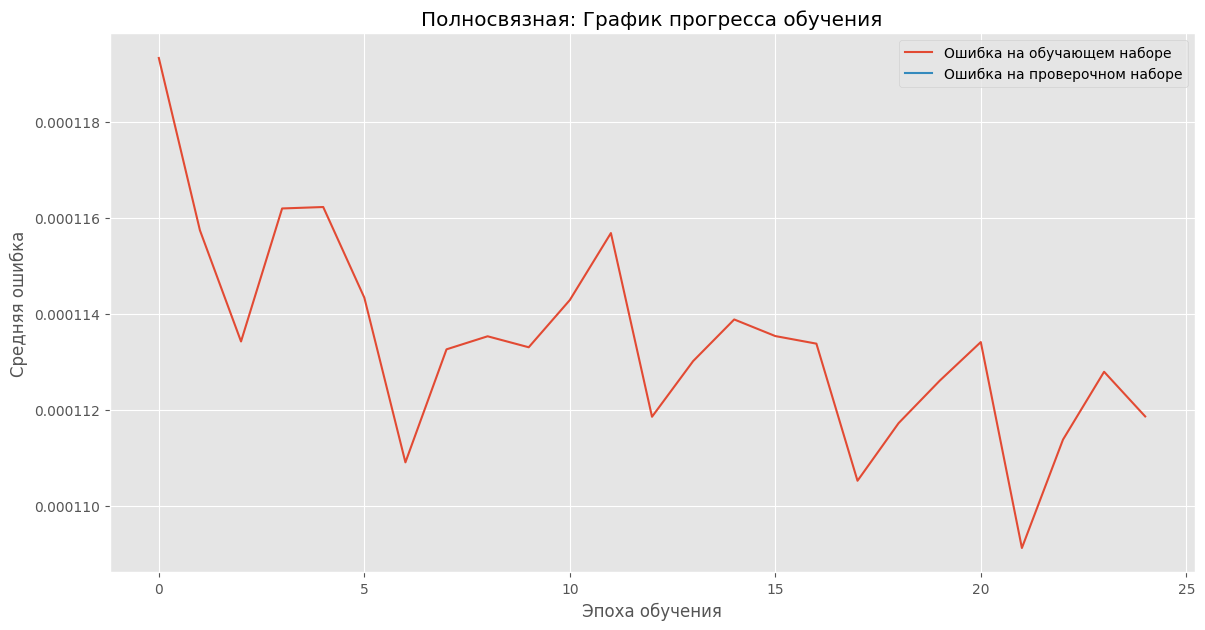

910/910 [==============================] - 2s 2ms/step


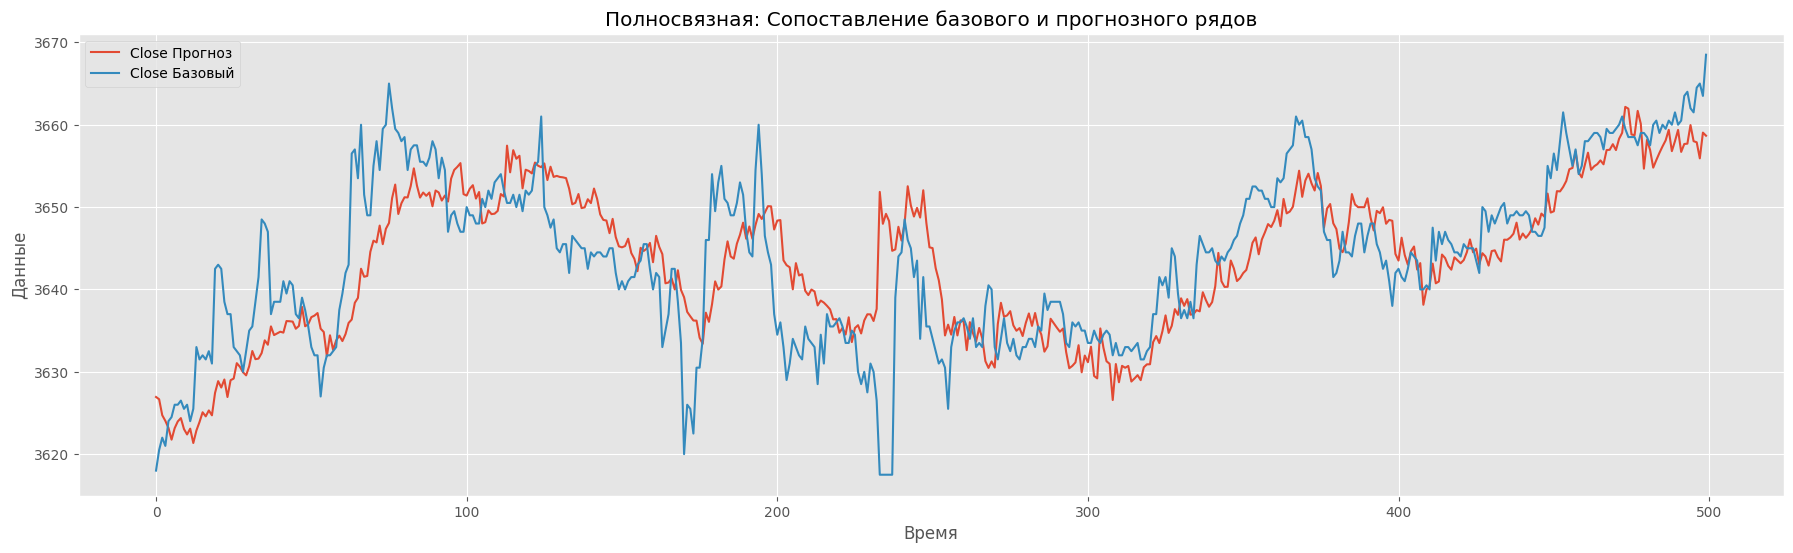

In [ ]:
model_dense = Sequential() # Модель MLP

model_dense.add(Dense(150, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))
 # Модель MLP обучение с разными значениями learning_rate и вывод графиков
train_eval_net(model_dense, train_datagen, val_datagen, [(10, Adam(learning_rate=1e-4)),
                                                         (25, Adam(learning_rate =1e-5)),
                                                         (25, Adam(learning_rate =1e-6))],
               title='Полносвязная', x_test=x_test, y_test=y_test, y_scaler=y_scaler)

**Создание и обучение сети с использованием одномерной свертки**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 296, 64)           1664      
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1  (None, 146, 64)           0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 9344)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               934500    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                      

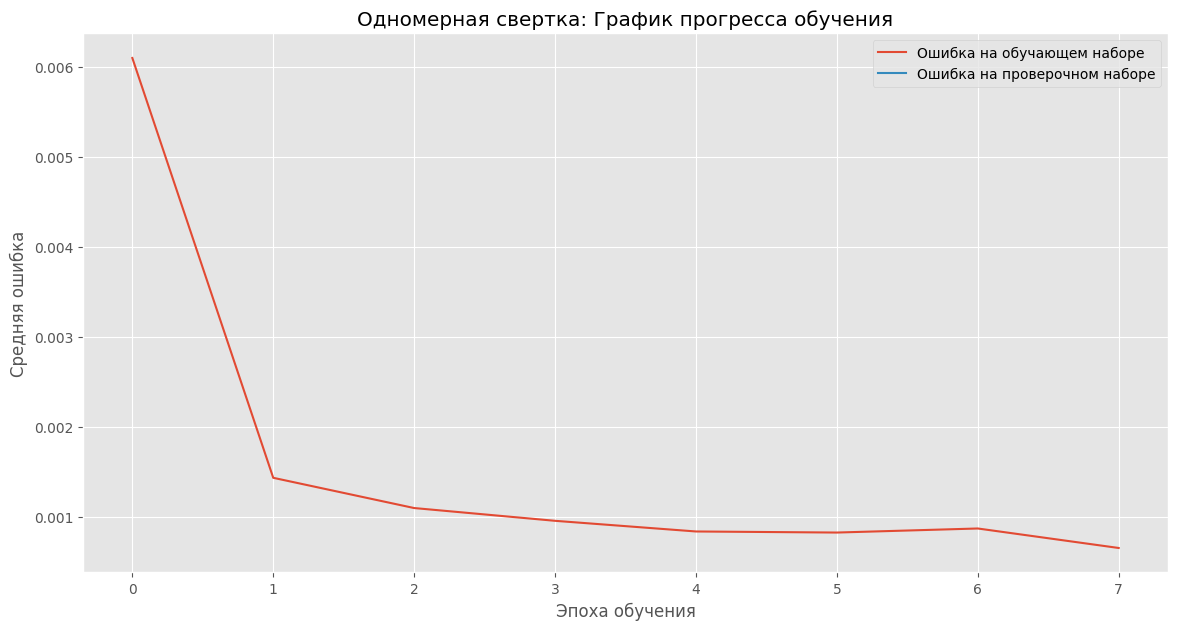

910/910 [==============================] - 2s 2ms/step


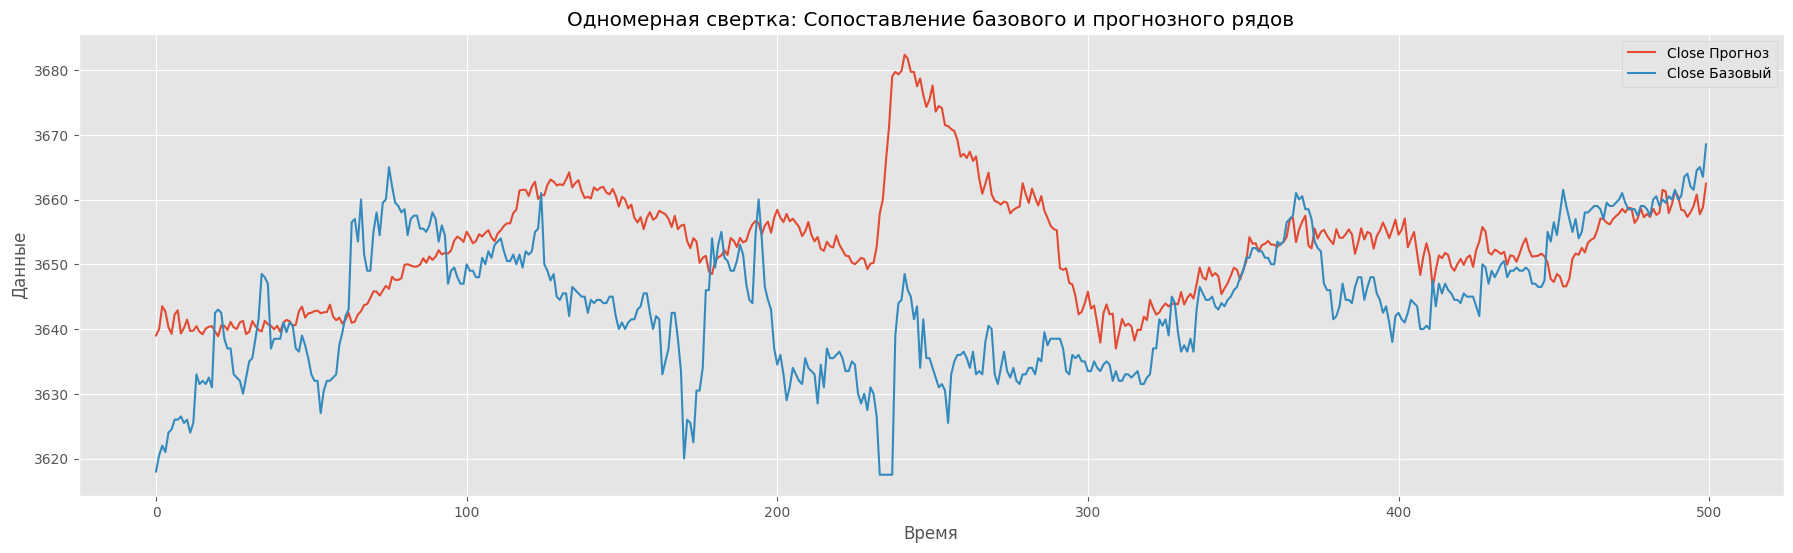

Обучение 5 эпох
Epoch 1/5
397/397 [==============================] - 6s 13ms/step - loss: 3.0481e-04 - val_loss: nan
Epoch 2/5
397/397 [==============================] - 4s 11ms/step - loss: 3.0406e-04 - val_loss: nan
Epoch 3/5
397/397 [==============================] - 4s 9ms/step - loss: 2.8444e-04 - val_loss: nan
Epoch 4/5
397/397 [==============================] - 7s 16ms/step - loss: 2.8593e-04 - val_loss: nan
Epoch 5/5
397/397 [==============================] - 4s 10ms/step - loss: 2.7662e-04 - val_loss: nan


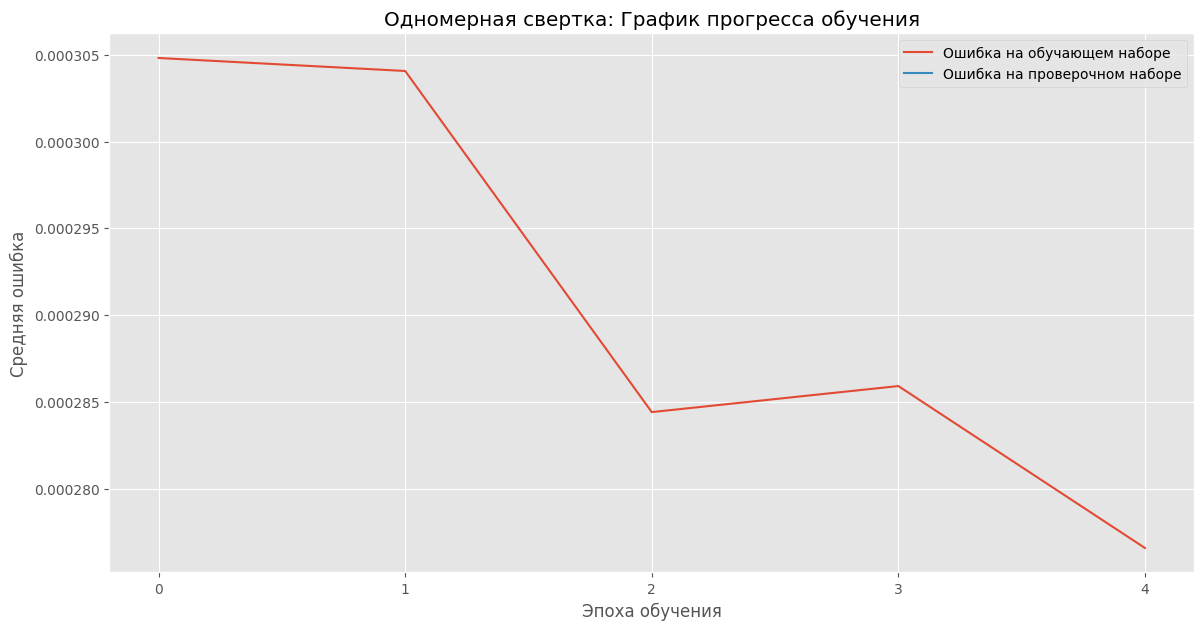

910/910 [==============================] - 2s 2ms/step


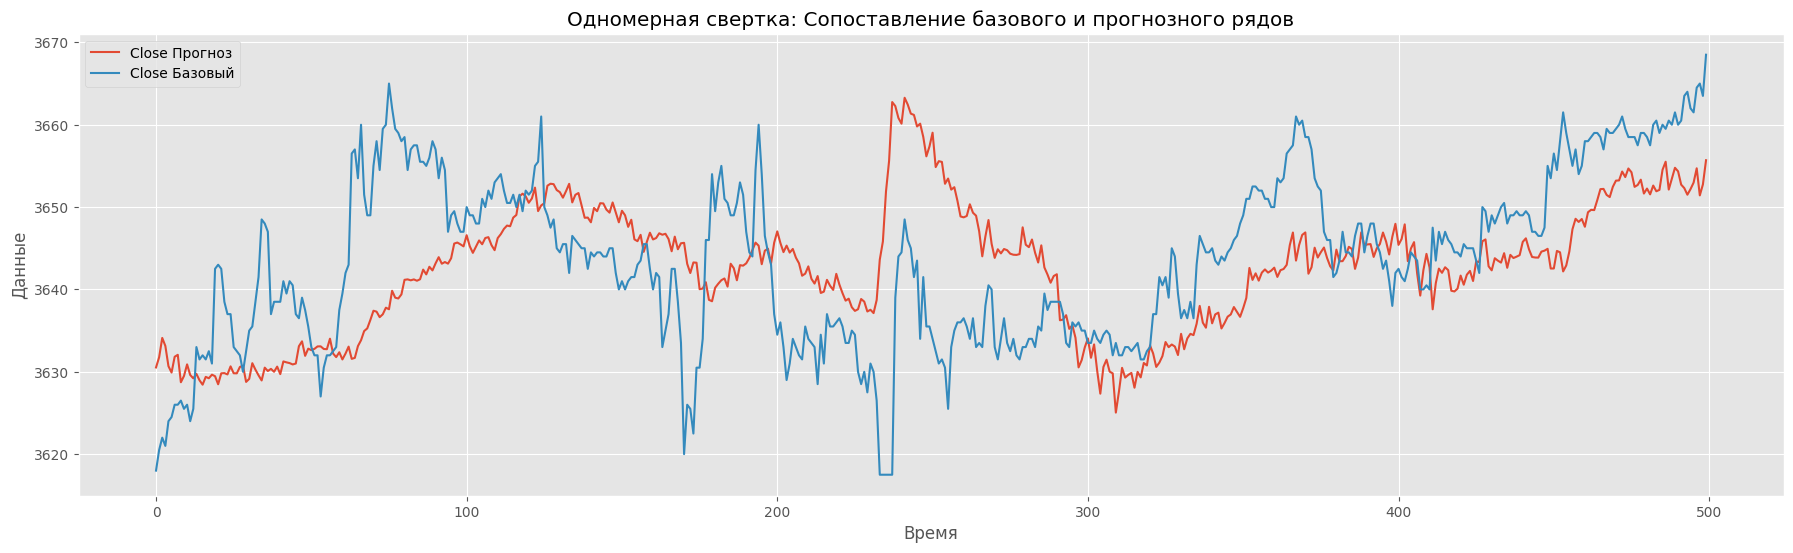

In [ ]:
model_conv = Sequential() # Модель Conv1D
model_conv.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))
# Модель Conv1D обучение с разными значениями learning_rate

train_eval_net(model_conv, train_datagen, val_datagen, [(8, Adam(learning_rate=1e-4)),
                                                        (5, Adam(learning_rate=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

**Создание и обучение сети с использованием рекуррентного слоя**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 220       
                                                                 
 dense_4 (Dense)             (None, 10)                60        
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 291 (1.14 KB)
Trainable params: 291 (1.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Обучение 8 эпох
Epoch 1/8
397/397 [==============================] - 13s 26ms/step - loss: 0.0197 - val_loss: nan
Epoch 2/8
397/397 [==============================] - 9s 23ms/step - loss: 0.0050 - val_loss: nan
Epoch 3/8
397/397 [==============================] - 10s 25ms/step - loss: 0.

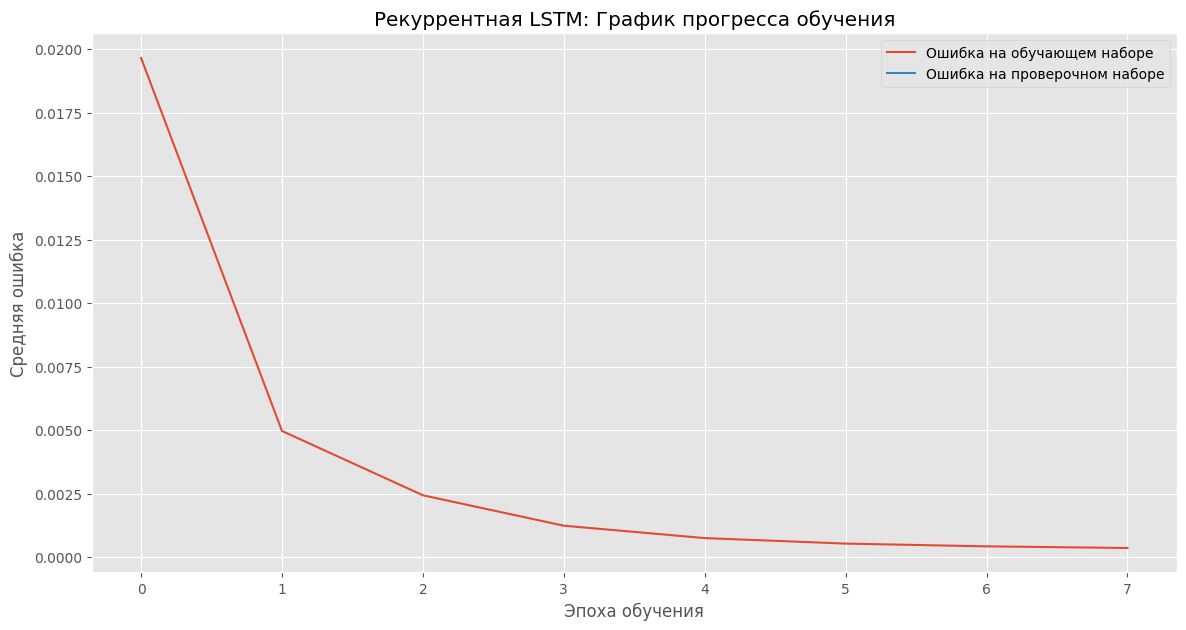

910/910 [==============================] - 5s 5ms/step


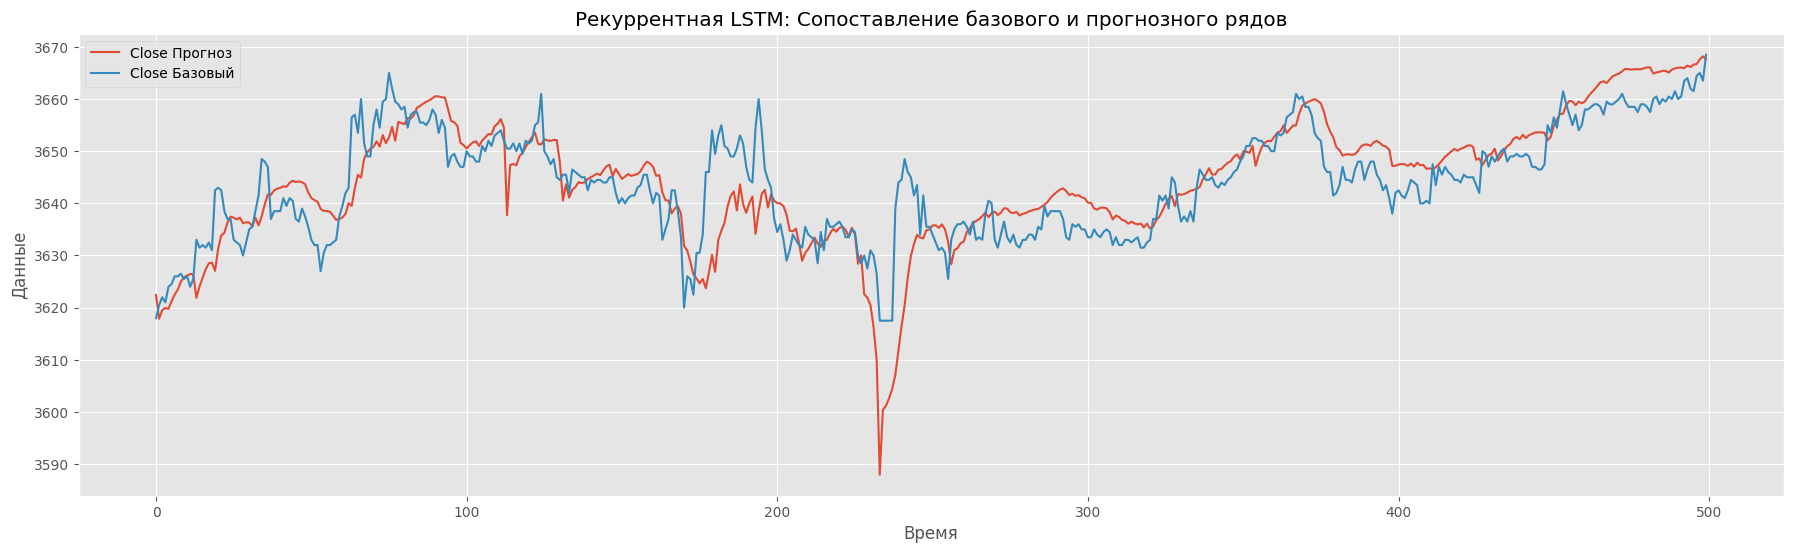

Обучение 5 эпох
Epoch 1/5
397/397 [==============================] - 12s 24ms/step - loss: 3.1719e-04 - val_loss: nan
Epoch 2/5
397/397 [==============================] - 10s 25ms/step - loss: 3.0724e-04 - val_loss: nan
Epoch 3/5
397/397 [==============================] - 10s 25ms/step - loss: 3.0212e-04 - val_loss: nan
Epoch 4/5
397/397 [==============================] - 10s 25ms/step - loss: 2.9601e-04 - val_loss: nan
Epoch 5/5
397/397 [==============================] - 9s 23ms/step - loss: 2.9110e-04 - val_loss: nan


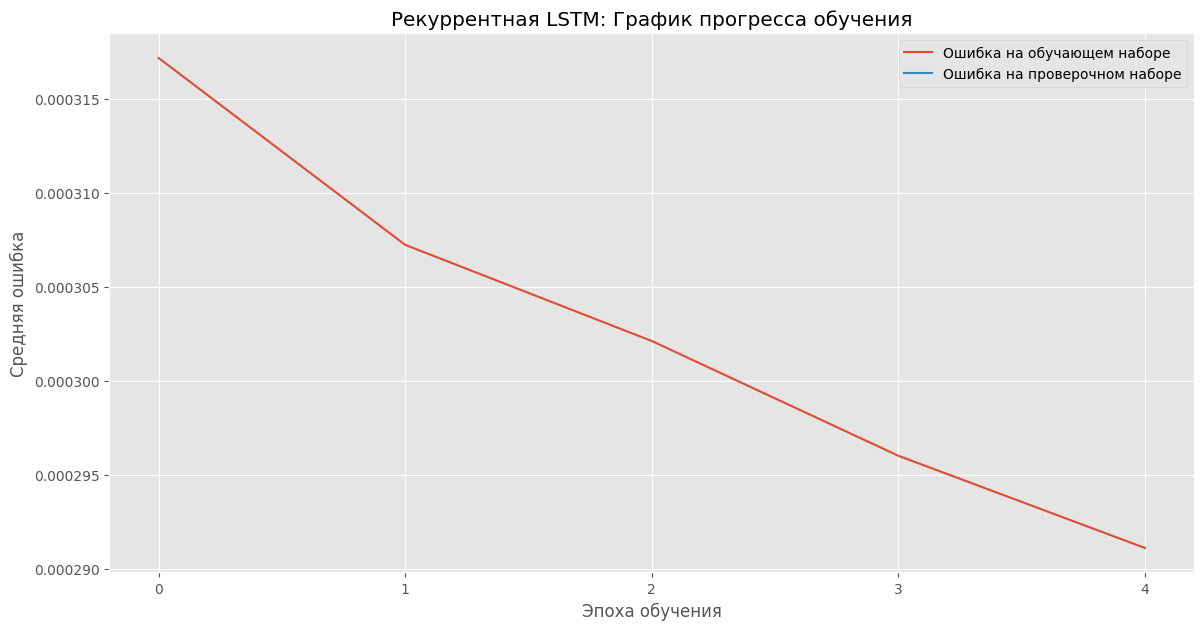

910/910 [==============================] - 6s 6ms/step


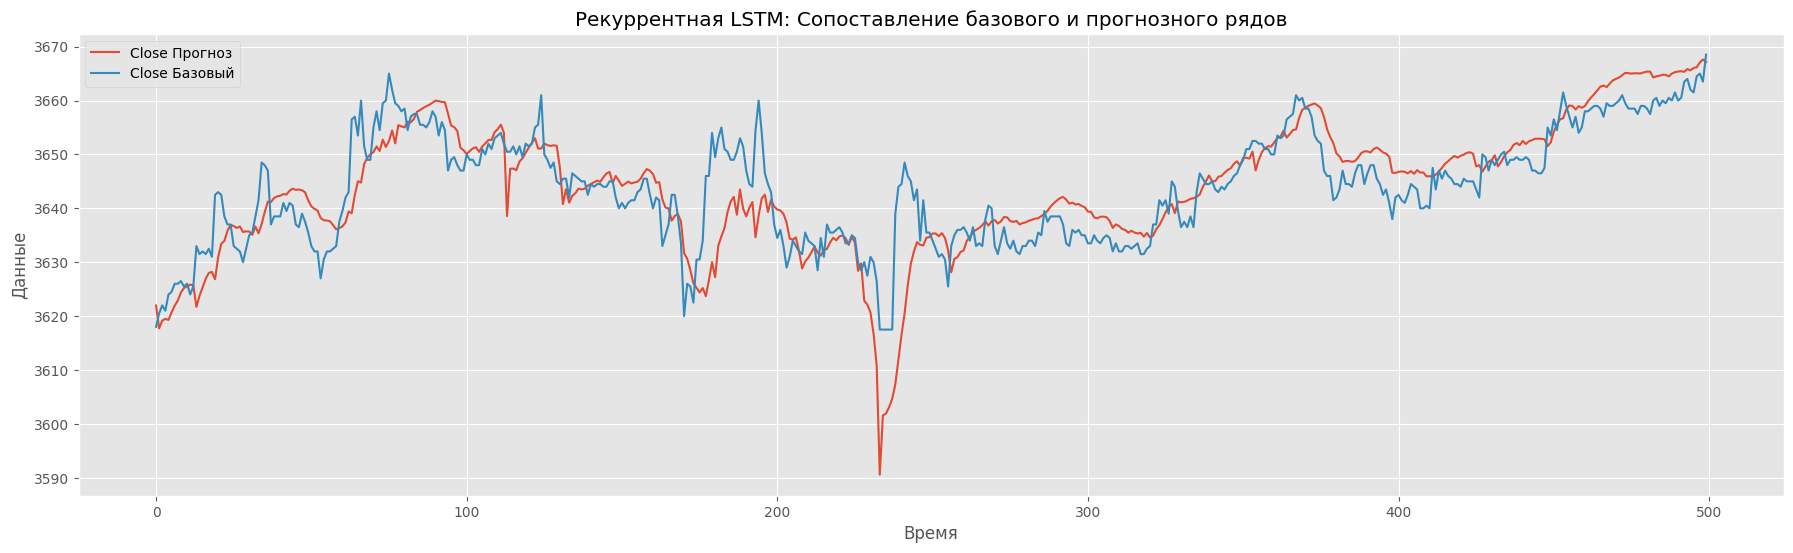

In [ ]:
model_lstm = Sequential()  # Модель LSTM
model_lstm.add(LSTM(5, input_shape=x_test.shape[1:]))
model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(y_test.shape[1], activation='linear'))
# Модель LSTM обучение с разными значениями learning_rate
train_eval_net(model_lstm, train_datagen, val_datagen, [(8, Adam(learning_rate=1e-4)),(5, Adam(learning_rate=1e-5))],
               x_test, y_test, y_scaler, title='Рекуррентная LSTM')

**Задание 1.**

В задании используется база курса акций Course.csv (ссылка https://drive.google.com/file/d/1LlQd1xtjO47h-GO94BK704Jp0F6h5z6I/view?usp=sharing).
1.	Создайте и  обучите простую полносвязную сеть для прогнозирования временного ряда (только показатель close) и выведите график ошибки. Постройте графики сравнения предсказания с оригинальным значением временного ряда.
2.	Создайте и обучите сверточную сеть для прогнозирования (только показатель close) и выведите график ошибки. Постройте графики сравнения предсказания с оригинальным значением временного ряда.
3.	Создайте и обучите сеть для прогнозирования с использованием LSTM слоя.
5.  Выведите лучшую архитектуру сети.



**ВОПРОСЫ**

1. Какую архитектуру сети предпочтительно использовать в задаче прогнозирования значений временных рядов?

**Ваш ответ**
Использование слоя LSTM (Long Short-Term Memory) в задачах прогнозирования значений временных рядов предпочтительно по нескольким причинам:

Долгосрочные зависимости: LSTM спроектированы для решения проблемы исчезающего градиента, которая возникает в стандартных RNN при обучении на длительных последовательностях.

Избегание затмения градиента: LSTM имеют специализированные механизмы (входные, выходные и забывательные ворота), которые регулируют поток информации.

Гибкость: LSTM могут обрабатывать данные с различной временной структурой, включая нерегулярные временные интервалы и последовательности переменной длины. Это делает их подходящими для ряда реальных задач прогнозирования временных рядов.

Способность к обучению на последовательностях: LSTM хорошо справляются с задачами, где порядок данных существенен. Временные ряды часто имеют временную зависимость и сезонные паттерны, которые LSTM могут научиться распознавать.

Начальная настройка состояния: Они могут быть хорошо инициализированы, и при необходимости заранее подготовлены для определенного контекста.

Производительность: Во многих случаях LSTM показывают лучшие результаты по сравнению с другими архитектурами для задач прогнозирования временных рядов, особенно когда речь идет о сложных данных с разнообразными паттернами.

В целом, LSTM являются мощным инструментом для решения задач временных рядов благодаря своей способности эффективно обрабатывать и сохранять информацию о временных зависимостях, что делает их предпочтительным выбором в этой области.



